In [1]:
import torch
import matplotlib.pyplot as plt

from src.dimension_reduction.principal_geodesic_analysis.vector.l2_tangent_space_pca import l2TangentSpacePCAVectorSolver
from src.manifolds.euclidean.vector.pullback.standard.affine_unbend_pullback import AffineUnbendStandardPullbackVectorEuclidean
from src.manifolds.isometrized_euclidean.vector import l2IsometrizedVectorEuclidean
from src.multimodal.sum_of_diagonal_gaussian import SumOfDiagonalGaussian

### Set up geometry ###

/Users/wdiepeveen/Documents/Postdoc/projects/2 - Riemannian geometry-based fairness in data science/src/iso-Riemannian-geometry/.venv/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


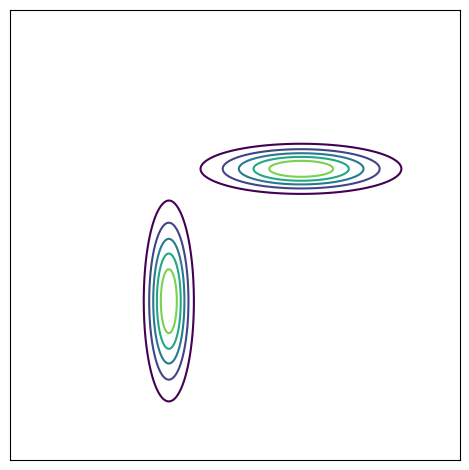

In [2]:
offset, a1, a2, w1, w2 = 5., 1/4, 4, 1, 1
double_gaussian = SumOfDiagonalGaussian(torch.tensor([[a1, a2], [a2, a1]]), torch.tensor([[-offset, 0.], [0., offset]]), torch.tensor([w1, w2]))

xx = torch.linspace(-6.0 - offset, 6.0, 500)
yy = torch.linspace(-6.0, 6.0 + offset, 500)
x_grid, y_grid = torch.meshgrid(xx, yy)

xy_grid = torch.zeros((*x_grid.shape,2))
xy_grid[:,:,0] = x_grid
xy_grid[:,:,1] = y_grid

density = torch.exp(double_gaussian.log_density(xy_grid.reshape(-1,2)).reshape(x_grid.shape))
levels = torch.linspace(density.min(), density.max(), 7)  # Adjust the number of levels as needed        # Retrieve the automatically generated levels
new_levels = levels[1:]         # Remove the first (smallest) level

plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/density.eps")
plt.show()

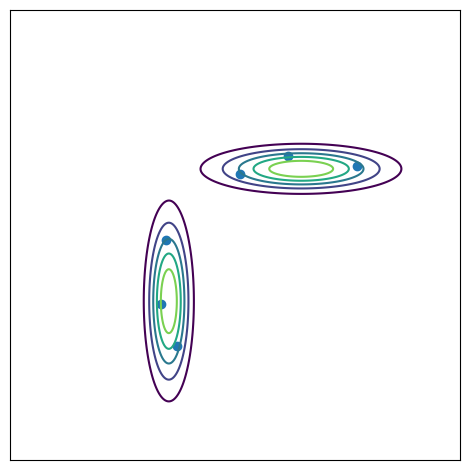

In [3]:
# special points
x0 = torch.tensor([0.3 - offset,-1.7])
x1 = torch.tensor([-0.3 - offset,-0.1])
x2 = torch.tensor([-0.1 - offset,2.3])

y0 = torch.tensor([-2.3,-0.2 + offset])
y1 = torch.tensor([-0.5,0.5 + offset])
y2 = torch.tensor([2.1,0.1 + offset])

data = torch.cat([x0[None], x1[None], x2[None], y0[None], y1[None], y2[None]],0)

plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/data.eps")
plt.show()

### Naive Riemannian data analysis ###

In [4]:
# Construct pullback manifold
manifold = AffineUnbendStandardPullbackVectorEuclidean()

In [5]:
# compute geodesic
t = torch.linspace(0.,1.,20)

geodesic = manifold.geodesic(x0,y2,t).detach().numpy()

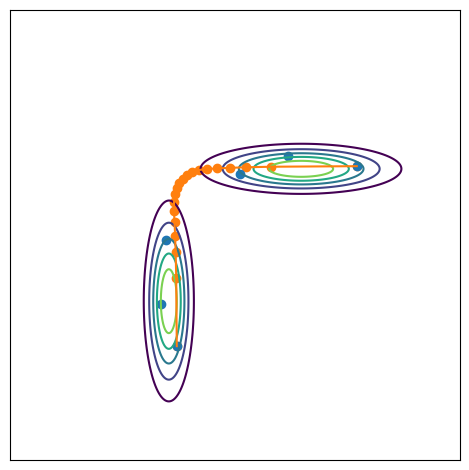

In [6]:
# plot geodesic
plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.plot(geodesic[:,0], geodesic[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(geodesic[:,0], geodesic[:,1],  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(data[:,0], data[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/geodesic.eps")
plt.show()

In [7]:
# compute barycentre
bary = manifold.barycentre(data)

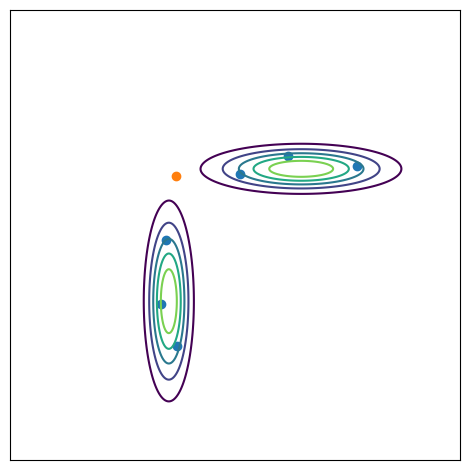

In [8]:
# plot barycentre
plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/barycentre.eps")
plt.show()

In [9]:
# construct l2-pga solver
l2_pga_solver_bary = l2TangentSpacePCAVectorSolver(data, manifold, bary)

In [10]:
# compute low rank approximations
Xi_bary, exp_bary_Xi, _ = l2_pga_solver_bary.solve(1) # compute rank 1 approximation

Computing rank 1 approximation on tangent space
Computing rank 1 approximation on euclidean space
Computing rank 1 errors


In [11]:
# compute learned manifold
log_bary_endpoints = torch.stack([1.011 * Xi_bary[-1], 1.001 * Xi_bary[0]],dim=0)
end_points = manifold.exp(bary, log_bary_endpoints)
mfld_fit = manifold.geodesic(end_points[0], end_points[1], t)

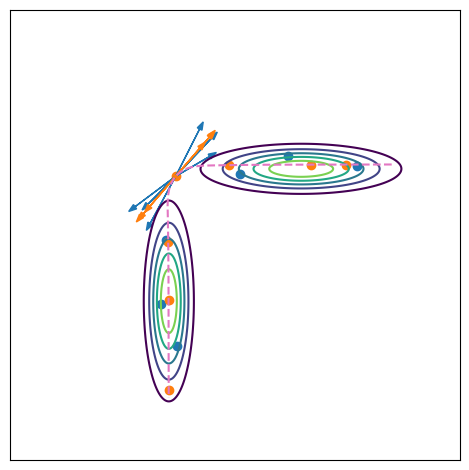

In [12]:
# plot tangent space approximations
plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
for i in range(l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], l2_pga_solver_bary.log_x_data[i, 0], l2_pga_solver_bary.log_x_data[i, 1], head_width=0.2, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for i in range(l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], Xi_bary[i, 0], Xi_bary[i, 1], head_width=0.2, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(exp_bary_Xi[:,0], exp_bary_Xi[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(mfld_fit[:,0], mfld_fit[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][6], linestyle='--')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/l2-pga.eps")
plt.show()

In [13]:
z0 = torch.tensor([-5, -4]).float()
z1 = torch.tensor([4, 5]).float()
mfld_geodesic = manifold.geodesic(z0, z1, t)

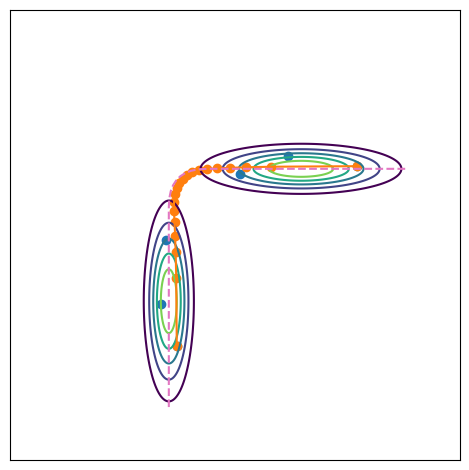

In [14]:
plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.plot(geodesic[:,0], geodesic[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(geodesic[:,0], geodesic[:,1],  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(mfld_geodesic[:,0], mfld_geodesic[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][6], linestyle='--')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/manifold.eps")
plt.show()

### Isometrized Riemannian data analysis ###

In [15]:
iso_manifold = l2IsometrizedVectorEuclidean(manifold, num_intervals=100)

In [16]:
# compute geodesic
t = torch.linspace(0.,1.,20)

iso_geodesic = iso_manifold.geodesic(x0,y2,t).detach().numpy()

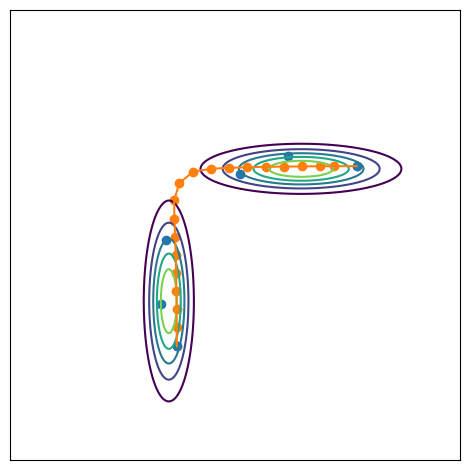

In [17]:
# plot geodesic
plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.plot(iso_geodesic[:,0], iso_geodesic[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(iso_geodesic[:,0], iso_geodesic[:,1],  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(data[:,0], data[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/iso-geodesic.eps")
plt.show()

In [18]:
# construct l2-pga solver
iso_l2_pga_solver_bary = l2TangentSpacePCAVectorSolver(data, iso_manifold, bary)

In [19]:
# compute low rank approximations
iso_Xi_bary, iso_exp_bary_Xi, _ = iso_l2_pga_solver_bary.solve(1) # compute rank 1 approximation

Computing rank 1 approximation on tangent space
Computing rank 1 approximation on euclidean space
Computing rank 1 errors


In [20]:
# compute learned manifold
iso_log_bary_endpoints = torch.stack([1.015 * Xi_bary[-1].norm() / iso_Xi_bary[-1].norm() * iso_Xi_bary[-1], 1.004 * Xi_bary[0].norm() / iso_Xi_bary[0].norm() * iso_Xi_bary[0]],dim=0)
iso_end_points = manifold.exp(bary, iso_log_bary_endpoints)
iso_mfld_fit = iso_manifold.geodesic(iso_end_points[0], iso_end_points[1], t)
print(iso_end_points)

tensor([[ 3.9997,  5.2020],
        [-4.9669, -3.9012]])


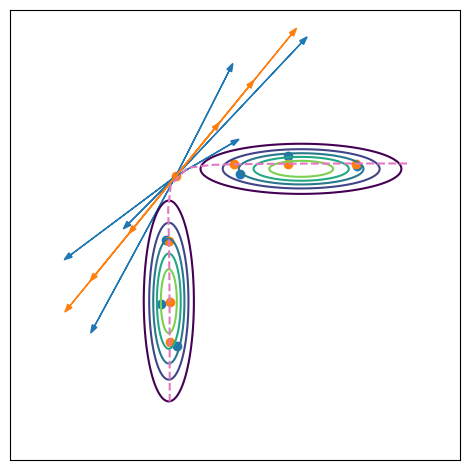

In [21]:
# plot tangent space approximations
plt.contour(x_grid, y_grid, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
for i in range(iso_l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], iso_l2_pga_solver_bary.log_x_data[i, 0], iso_l2_pga_solver_bary.log_x_data[i, 1], head_width=0.2, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for i in range(iso_l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], iso_Xi_bary[i, 0], iso_Xi_bary[i, 1], head_width=0.2, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(iso_exp_bary_Xi[:,0], iso_exp_bary_Xi[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(iso_mfld_fit[:,0], iso_mfld_fit[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][6], linestyle='--')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-unbend-pullback/iso-l2-pga.eps")
plt.show()

### Comparing naive and isometrized ###

In [22]:
# Compute geodesic relative rmse from the barycentre
squared_geo_errors = torch.zeros(data.shape[0])
dists = ((data - bary)**2).sum(1)
for i, x_i in enumerate(data):
    geodesic_i = manifold.geodesic(bary, x_i, t)
    iso_geodesic_i = iso_manifold.geodesic(bary, x_i, t)
    squared_geo_errors[i] = ((geodesic_i - iso_geodesic_i)**2).mean(0).sum()

geo_rel_rmse = (squared_geo_errors.mean() / dists.mean()).sqrt()
print(geo_rel_rmse)

tensor(0.2428)


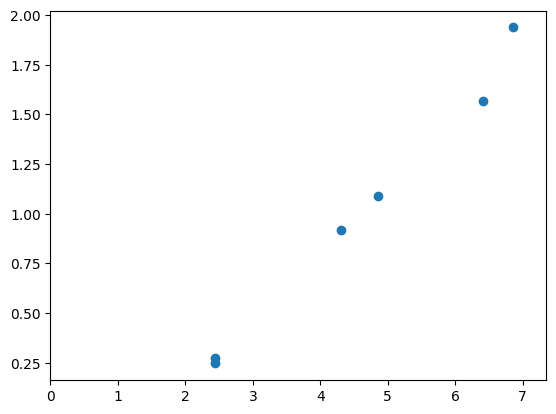

In [23]:
# Make scatter plot
plt.scatter(dists.sqrt(), squared_geo_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()+0.5])
plt.show()

In [24]:
# Compute low rank relative rmse from the barycentre
squared_low_rank_errors = ((data - exp_bary_Xi)**2).sum(1)
low_rank_rel_rmse = (squared_low_rank_errors.mean() / dists.mean()).sqrt()

squared_low_rank_iso_errors = ((data - iso_exp_bary_Xi)**2).sum(1)
iso_low_rank_rel_rmse = (squared_low_rank_iso_errors.mean() / dists.mean()).sqrt()

print(low_rank_rel_rmse)
print(iso_low_rank_rel_rmse)

tensor(0.1741)
tensor(0.0606)


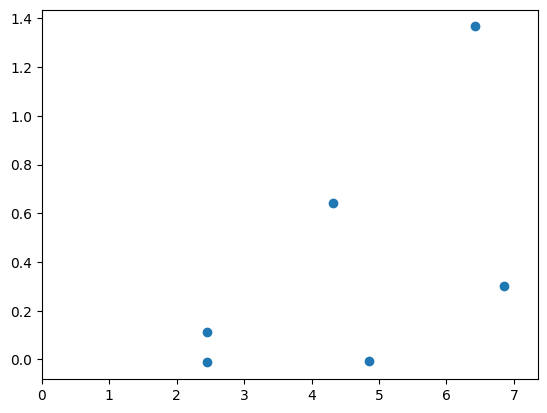

In [25]:
# Make scatter plot
plt.scatter(dists.sqrt(), squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()+0.5])
plt.show()